# Import relevant libraries/modules etc

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio, xarray_to_rasterio_by_band
import rasterstats

In [2]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar
pbar = ProgressBar()
pbar.register()

# Read NetCDF files in to create dataset with all data in

In [3]:
PM25 = xr.open_mfdataset(r'C:\MAIACData\nc_monthly_daily\*PM25.nc', concat_dim='time')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

In [ ]:
# I think not specifying any chunks explicitly seems to work best - see above
#PM25 = xr.open_mfdataset(r'D:\MAIAC_Data\Europe\h00v01\nc_monthly\*PM25.nc', chunks={'time':5, 'x':500, 'y':500}, concat_dim='time')

In [ ]:
PM25['data'].time.min()

# Extract data over one pixel

I skipped this bit...(Robin)

In [4]:
ts = PM25['data'].isel(x=1082, y=1063).dropna('time')

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1min 10.8s


In [5]:
ts

<xarray.DataArray 'data' (time: 1421)>
dask.array<getitem..., shape=(1421,), dtype=float32, chunksize=(7,)>
Coordinates:
    x        float64 4.119e+05
    y        float64 9.357e+04
  * time     (time) datetime64[ns] 2000-10-01 2000-10-10 2000-10-12 ...
Attributes:
    affine: [ -9.47639631e+05   1.25654304e+03   0.00000000e+00   1.42927781e+06
   0.00000000e+00  -1.25654304e+03]
    crs: +init=epsg:27700

In [6]:
result = ts.load()

[########################################] | 100% Completed | 19.8s


In [7]:
result = result.to_dataframe()

In [ ]:
result.dropna()

In [8]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25_daily.csv')

# Group data
- merge multiple images per day using the maximum AOT estimates

In [4]:
PM25 = PM25['data']

In [5]:
m = PM25.mean(dim='time', keep_attrs=True)

In [6]:
m = m.load()

[########################################] | 100% Completed |  1min  2.2s


D:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
figure(figsize=(20, 8))
m.plot()

In [7]:
from dask.dot import dot_graph

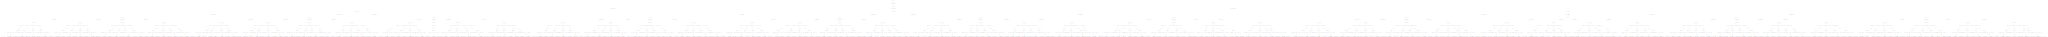

In [16]:
##dot_graph(, format='svg')

In [12]:
from dask.dot import to_graphviz

In [ ]:
dot_graph(m.data.dask)

In [ ]:
dot_graph(m.data.dask, filename='robin2.pdf', format='pdf')

In [ ]:
reordered_PM25 = PM25.isel(time=np.argsort(PM25.time))

In [ ]:
Daily_PM25 = reordered_PM25.resample('D', dim='time', how='max')
Daily_PM25 = Daily_PM25.dropna(dim='time', how='all')

In [ ]:
Daily_PM25.time

In [ ]:
Daily_PM25.attrs

# Analysis
## overall average of every pixel

The next four cells were added by Robin for profiling - ignore them for the moment :P

In [28]:
om = PM25.mean(dim='time', keep_attrs=True)

In [29]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

In [30]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof:
    om.load()

[########################################] | 100% Completed |  1min 14.6s


D:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [27]:
from dask.diagnostics import visualize
visualize([prof, rprof], show=True)

In [18]:
overall_mean = PM25.mean(dim='time', keep_attrs=True)

In [19]:
overall_mean.attrs

OrderedDict([('affine',
              array([ -9.47639631e+05,   1.25654304e+03,   0.00000000e+00,
                       1.42927781e+06,   0.00000000e+00,  -1.25654304e+03])),
             ('crs', '+init=epsg:27700')])

In [ ]:
with ProgressBar():
    res = overall_mean.load()

In [20]:
xarray_to_rasterio(overall_mean, r'D:\Annies_Dissertation\Analysis\overall_mean.tif')

[########################################] | 100% Completed |  1min 15.3s


D:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Averages
### Monthly

In [34]:
monthly_mean = PM25.groupby('time.month').mean(dim='time', keep_attrs=True)

In [35]:
monthly_mean.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
monthly_mean.attrs

OrderedDict([('affine',
              array([ -9.47639631e+05,   1.25654304e+03,   0.00000000e+00,
                       1.42927781e+06,   0.00000000e+00,  -1.25654304e+03])),
             ('crs', '+init=epsg:27700')])

In [ ]:
figure(figsize=(20, 12))
monthly.plot(col='month', robust=True)

In [60]:
xarray_to_rasterio_by_band(monthly_mean, r'D:\Annies_Dissertation\Analysis\monthly\monthly_mean_', dim='month')

Exported 1
Exported 2
Exported 3
Exported 4
Exported 5
Exported 6
Exported 7
Exported 8
Exported 9
Exported 10
Exported 11
Exported 12


### Seasonal

In [50]:
seasonal_mean = PM25.groupby('time.season').mean(dim='time', keep_attrs=True)

In [48]:
seasonal_mean.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [ ]:
figure(figsize=(20, 12))
seasonal_mean.plot(col='season', robust=True)

In [63]:
xarray_to_rasterio_by_band(seasonal_mean, r'D:\Annies_Dissertation\Analysis\seasonal\seasonal_mean_', dim='season')

Exported DJF
Exported JJA
Exported MAM
Exported SON


### Yearly

In [52]:
yearly_mean = PM25.groupby('time.year').mean(dim='time', keep_attrs=True)

In [56]:
yearly_mean.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * year     (year) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...

In [ ]:
figure(figsize=(20, 12))
yearly_mean.plot(col='year', robust=True)

In [64]:
xarray_to_rasterio_by_band(yearly_mean, r'D:\Annies_Dissertation\Analysis\yearly\yearly_mean_', dim='year')

Exported 2000
Exported 2001
Exported 2002
Exported 2003
Exported 2004
Exported 2005
Exported 2006
Exported 2007
Exported 2008
Exported 2009
Exported 2010
Exported 2011
Exported 2012
Exported 2013
Exported 2014


## Standard deviation of AP for each pixel over time- not currently what i want to do!

In [ ]:
std = PM25.groupby('time.year').std(dim = 'time', keep_attrs=True)

In [54]:
std = PM25.std(dim = 'time', keep_attrs=True)

In [45]:
std.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...

In [ ]:
figure(figsize=(20, 12))
std.plot(col='year', robust=True)

In [55]:
xarray_to_rasterio(std, r'D:\Annies_Dissertation\Analysis\overall_std.tif')

[                                        ] | 0% Completed |  1.2s

D:\Anaconda3\lib\site-packages\dask\array\reductions.py:278: RuntimeWarning: invalid value encountered in true_divide
  u = total/n


[#                                       ] | 2% Completed |  7.2s

D:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 17.2s


# Count of values that aren't missing

In [67]:
observations = PM25.count(dim='time', keep_attrs=True)

In [68]:
xarray_to_rasterio(observations, r'D:\Annies_Dissertation\Analysis\observations_count.tif')

[########################################] | 100% Completed |  1min 13.4s


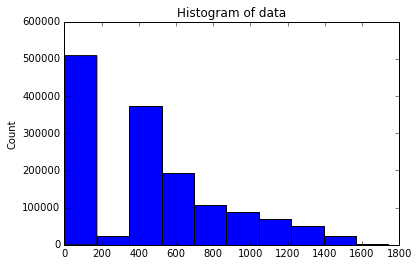

In [71]:
count_histo = observations.plot.hist()
savefig(r'D:\Annies_Dissertation\Analysis\count_histogram.jpeg')

In [ ]:
figure(figsize=(20, 12))
observations.plot(robust=True)

# Zonal Statistics

In [ ]:
from rasterstats import zonal_stats
zonal_stats(r"D:\Annies_Dissertation\Data\LSOA\LSOA.shp", 
            r"D:\Annies_Dissertation\MAIAC_Test\subset\Projected\2014\MAIACAAOT.h00v01.20140041325.hdf_PM25.tif",
            stats="count min mean max median")

In [ ]:
from rasterstats import zonal_stats
zonal_stats(r"D:\Annies_Dissertation\Data\LSOA\LSOA.shp", 
            r"D:\Annies_Dissertation\MAIAC_Test\subset\Projected\2014\MAIACAAOT.h00v01.20140041325.hdf_PM25.tif",
            stats="count min mean max median", geojson_out=True)